In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [6]:
tf.__version__

'2.19.0'

In [7]:
# Enable memory growth (prevents TensorFlow from pre-allocating all VRAM)

from tensorflow.python.client import device_lib

gpus = tf.config.experimental.list_physical_devices('GPU')

print("Num GPUs Available:", len(gpus))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
print(device_lib.list_local_devices())

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available: 1
Built with CUDA: True
Built with GPU support: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2971251682201432631
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3760193536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8887712528532831685
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1756831614.909195   24027 gpu_device.cc:2019] Created device /device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
# Enable memory growth (prevents TensorFlow from pre-allocating all VRAM)

gpus = tf.config.experimental.list_physical_devices('GPU')

print("Num of GPUs", len(gpus))

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num of GPUs 1


**load the data**

In [9]:
currentDir = os.getcwd()

Train_filePath = os.path.join(currentDir, "Flower Classification Dataset/train")
Test_filePath = os.path.join(currentDir, "Flower Classification Dataset/test")
Validation_filePath = os.path.join(currentDir, "Flower Classification Dataset/valid")

Train_data = tf.keras.preprocessing.image_dataset_from_directory(
    Train_filePath,
    labels = 'inferred',
    image_size = (224,224),
    batch_size = 32,
    #validation_split = 0
)

Test_data = tf.keras.preprocessing.image_dataset_from_directory(
    Test_filePath,
    labels = 'inferred',
    image_size = (224,224),
    batch_size = 32,
    #validation_split = 0
)

Validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    Validation_filePath,
    labels = 'inferred',
    image_size = (224,224),
    batch_size = 32,
    #validation_split = 0
)

#Split the dataset into input and target
# Input_validation= Validation_data.map(lambda image, lable: image)
# Target_validation= Validation_data.map(lambda image, lable: lable)

Found 4102 files belonging to 102 classes.


I0000 00:00:1756831618.470594   24027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2042 files belonging to 102 classes.
Found 2045 files belonging to 102 classes.


**Outline the model**

In [10]:
input_size = 50176
output_size = 102
hidden_layer_size = 128 #TODO: figure out the exact value

model = tf.keras.Sequential([
    # ReScale pixel values in the band [0, 1] 
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),

    # Augmentation (Adding randomization to the images)
    # ONLY USED IN TRAINING
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    
    # Conv 1
    tf.keras.layers.Conv2D(
        32, 
        (3,3), 
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        bias_regularizer=tf.keras.regularizers.l2(0.0001),
        padding='same'
    ), #TODO: Check if the combination of L1 and L2 works better for all layers
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Conv 2
    tf.keras.layers.Conv2D(
        64, 
        (3,3), 
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        bias_regularizer=tf.keras.regularizers.l2(0.0001),
        padding='same'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Conv 3
    tf.keras.layers.Conv2D(
        64, 
        (3,3), 
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        bias_regularizer=tf.keras.regularizers.l2(0.0001),
        padding='same'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Conv 4
    tf.keras.layers.Conv2D(
        128, 
        (3,3), 
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        bias_regularizer=tf.keras.regularizers.l2(0.0001),
        padding='same'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flattened Inputs
    tf.keras.layers.GlobalAveragePooling2D(), # Better than normal Flattening, reduces the dimensionality of feature maps
        #tf.keras.layers.Flatten(),
    
    # Dense Layers (Fully connected layers (FC Layers))
    tf.keras.layers.Dense(
        hidden_layer_size, 
        activation = 'relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        bias_regularizer=tf.keras.regularizers.l2(0.0001)
    ),
    #TODO: Check if dropping neurons actually prevents overfitting 
    #TODO: We can test other techniques besides dropping 
    tf.keras.layers.Dropout(0.5),

    # Didn't specify "softmax" activation function in the last layer 
    # to use the right order of opertions for loss calculations
    tf.keras.layers.Dense(output_size) 
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             

 Total params: 160,998 (628.90 KB)

 Trainable params: 160,422 (626.65 KB)

 Non-trainable params: 576 (2.25 KB)

**Choose the optimizer and the loss function**

In [11]:
lossFunction = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Internally applies "softmax" if "from_logits = True"
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#TODO: Add early stopping
model.compile(
    optimizer=optimizer,
    loss=lossFunction,
    metrics= ['accuracy']
)

**Training**

In [12]:
# Loggin Learning Rate Change

class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        if not hasattr(self, 'lrs'):
            self.lrs = []
        self.lrs.append(lr)

In [13]:
epoch_num= 50

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # metric to monitor
    factor=0.5,           # reduce LR by this factor
    patience=3,           # wait 3 epochs with no improvement
    min_lr=1e-6,          # lower bound for LR
    verbose=1             # print when LR is reduced
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # or 'val_accuracy'
    patience=5,           # stop if no improvement for 5 epochs
    restore_best_weights=True
)

lr_logger = LRTensorBoard()

history = model.fit(
    Train_data,
    validation_data=Validation_data,
    epochs=epoch_num,
    callbacks=[early_stop, lr_scheduler, lr_logger], 
    verbose= 2
)

Epoch 1/50


I0000 00:00:1756831624.459043   28226 cuda_dnn.cc:529] Loaded cuDNN version 90300


129/129 - 21s - 165ms/step - accuracy: 0.0736 - loss: 4.3193 - val_accuracy: 0.0406 - val_loss: 4.4861 - learning_rate: 1.0000e-03
Epoch 2/50
129/129 - 16s - 126ms/step - accuracy: 0.1190 - loss: 3.8232 - val_accuracy: 0.0362 - val_loss: 4.3481 - learning_rate: 1.0000e-03
Epoch 3/50
129/129 - 13s - 99ms/step - accuracy: 0.1619 - loss: 3.5205 - val_accuracy: 0.0733 - val_loss: 4.0666 - learning_rate: 1.0000e-03
Epoch 4/50
129/129 - 13s - 99ms/step - accuracy: 0.1802 - loss: 3.3431 - val_accuracy: 0.2372 - val_loss: 3.1624 - learning_rate: 1.0000e-03
Epoch 5/50
129/129 - 16s - 126ms/step - accuracy: 0.2114 - loss: 3.2008 - val_accuracy: 0.2724 - val_loss: 2.9013 - learning_rate: 1.0000e-03
Epoch 6/50
129/129 - 13s - 99ms/step - accuracy: 0.2328 - loss: 3.1148 - val_accuracy: 0.2665 - val_loss: 2.9067 - learning_rate: 1.0000e-03
Epoch 7/50
129/129 - 16s - 127ms/step - accuracy: 0.2496 - loss: 2.9921 - val_accuracy: 0.2582 - val_loss: 2.9897 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8:

**Evaluate the model on test data**

In [14]:
# test_loss, test_accuracy = model.evaluate(Test_data)
evaluation = model.evaluate(Test_data)
print(f"Evaluation: {evaluation}")
# print(f"Test accuracy: {test_accuracy}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4207 - loss: 2.2439
Evaluation: [2.2439498901367188, 0.42066600918769836]


**Plotting training information**

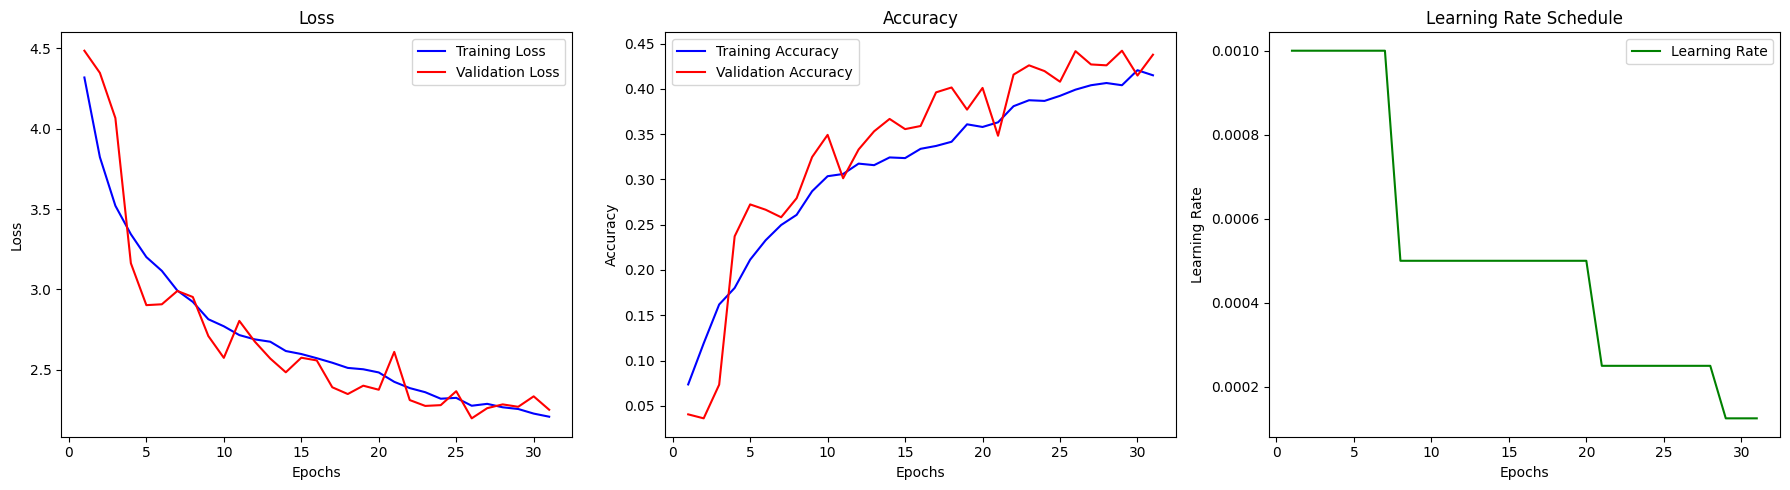

In [15]:
# --- Extract metrics ---
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
lrs = lr_logger.lrs  # learning rates logged
epochs = range(1, len(train_loss)+1)

# --- Plot everything ---
plt.figure(figsize=(18,5))

# Training & Validation Loss
plt.subplot(1,3,1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Training & Validation Accuracy
plt.subplot(1,3,2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Learning Rate
plt.subplot(1,3,3)
plt.plot(epochs, lrs, 'g-', label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

plt.tight_layout()
plt.show()